This notebook should walk through how we'll be reading in the data and give the basics on how to get started on making plots.  The matplotlib documentation (both official and on stackexchange) is usually pretty good, but can be tricky getting started.

Note that with a jupyter notebook you can designate cells as either code or markdown text, like this one is, for more comprehensive comments.


In [13]:
import numpy as np
import pandas as pd
import scipy as sc
import uproot as up
import matplotlib.pyplot as plt
#packages we'll need

%matplotlib inline 
#this is a ``magic command'' specific to display plots in-line in a jupyter notebook
#normally you would plot by calling a plt.show()


from matplotlib.colors import LogNorm
#need this for the colourbar of the 2D histogram

In [14]:

# merge get dataframes from .root files and 
def set_dataframe(num_towers, path):
    frames = []

    for t in range(1, num_towers + 1):
        new_path = path + str(t) + '.root'

        #load tower
        event = up.open(new_path)['tree']

        #recast the data as a pandas dataframe and append to frames
        frames.append(event.pandas.df())
    
    return pd.concat(frames)
    
    
    
my_path = '/Users/julianyocum/UROP/data/ds3564/ds3564Tower'

alldata = set_dataframe(19, my_path)

In [15]:
alldata

,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp
entry,,,,,,,,,,
0,350259,4,201.712,1,3.175603,3162,5.350868e+03,-2228.379725,2209.313868,6.922486e+03
1,350259,32,334.408,1,3.173095,3164,5.333960e+03,-4604.478149,3705.018311,7.599031e+03
2,350259,23,1922.776,1,3.209816,3208,4.736281e+03,-4649.411229,3223.717717,6.487084e+03
3,350259,6,3444.392,1,3.175244,3161,5.341670e+03,-4218.544189,3944.732849,7.330490e+03
4,350259,29,5731.368,1,3.168502,3158,5.415189e+03,-4729.856969,2827.517034,7.222236e+03
...,...,...,...,...,...,...,...,...,...,...
629575,350292,975,56754.517,0,9999.999000,3324,9.999999e+06,-5140.619446,134.950806,9.999999e+06
629576,350292,937,56872.128,1,3.177405,3176,5.286591e+03,-2585.631765,3640.902913,6.996134e+03
629577,350292,975,57397.425,0,9999.999000,7712,9.999999e+06,-5143.951182,118.415599,9.999999e+06


This displays the dataframe with all of our variables and events.

In [16]:
#to access a dataframe given by just one set of variables:
alldata['Run']
max(alldata['SelectedEnergy'])
max(alldata['Channel'])
max(alldata['Time'])

89308.504

In [17]:
#or more useful, to just access the array corresponding to one set of values:
alldata['Run'].values

array([350259, 350259, 350259, ..., 350292, 350292, 350292], dtype=uint32)

In [18]:
# returns array of event frequencies where channel - 1 is the index
def get_numchannelevents():
    # get num events per channel
    events = []
    for c in range(1,max(alldata['Channel']) + 1):
        events.append(len(alldata[alldata['Channel'] == c]))
    return events

events_per_channel = get_numchannelevents()

#print(events_per_channel)
#print(sum(events_per_channel)/ len(events_per_channel))

In [19]:
# find dead channels
def get_deadchannels(channel_events):
    ch = []
    for c in range(1,max(alldata['Channel']) + 1):     
        if channel_events[c - 1] == 0:
            ch.append(c)
    
    #for c in range()
    return ch

dead_channels = get_deadchannels(events_per_channel)

print("Dead channels are: " + str(dead_channels))

#alldata[alldata['Channel'] == 988]


Dead channels are: [117, 169, 792, 923]


In [20]:
from scipy import stats

#detect outliers using above threshold z-score
def get_noisychannels(channel_events):
    
    #detect outliers using z-score
    #threshold = 3.5
    #z_dist = np.abs(stats.zscore(channel_events))
    #return np.where(z_dist > threshold)
    
    #detect outliers using IQR
    threshold = 5
    Q1, Q3 = np.percentile(channel_events, 25), np.percentile(channel_events, 75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + IQR * threshold
    
    #print(channel_events[channel_events > upper_bound])
    
    return [c for c in range(1,max(alldata['Channel']) + 1) if channel_events[c - 1] > upper_bound]
    
    #return np.where(channel_events > upper_bound) 
    


    
noisy_channels = get_noisychannels(events_per_channel)

print("# of noisy channels: " + str(len(noisy_channels)) + "\n")

print("Noisy channels are: " + str(noisy_channels) + "\n")

print("Num of events per channel are: " + str([events_per_channel[i - 1] for i in noisy_channels]))


# of noisy channels: 17

Noisy channels are: [87, 361, 363, 364, 557, 558, 559, 570, 611, 713, 714, 715, 936, 973, 974, 975, 988]

Num of events per channel are: [70344, 333, 520, 539, 343, 415, 692, 317, 413, 620, 581, 3154, 483, 881, 926, 622849, 1405]


In [21]:
# get Dataframe which doesn't include noisy channels
not_noisydata = alldata[np.isin(alldata['Channel'],noisy_channels, invert=True)]

# get events above certain baseline + maxtobaseline from not_noisydata
louddata = not_noisydata[(not_noisydata['Baseline'] + not_noisydata['MaxToBaseline']) > 9000]

louddata

,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp
entry,,,,,,,,,,
6,350259,27,7191.136,1,3.175879,3637,23567.885857,-4515.251541,14154.884720,29155.087318
7,350259,28,7191.152,1,3.200379,3687,25765.831235,-5549.806880,15168.531703,29658.848249
98,350260,2,19239.648,1,3.165242,3517,31308.324329,-1669.523214,11263.895009,39683.776708
99,350260,1,19239.656,1,3.164472,3604,26767.777221,-2197.285110,11831.150467,31858.203222
100,350260,17,19239.664,1,3.359793,3754,31408.606063,-3511.258682,13117.887100,153361.492091
...,...,...,...,...,...,...,...,...,...,...
625959,350290,946,6267.936,1,3.146274,3127,33340.302933,-3856.221700,13447.789693,39082.955824
625964,350290,947,6267.984,1,3.242658,3206,26844.811556,-3487.122375,13077.729065,33053.434909
629270,350292,986,23742.688,1,3.145783,3462,36193.349092,-3413.161270,13032.366745,45656.897875


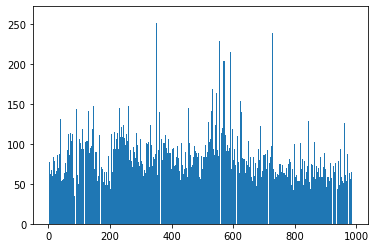

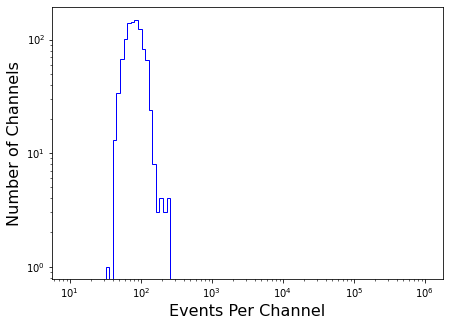

In [22]:
#CAN COMPARE WITH alldata VS not_noisydata

array=plt.hist(not_noisydata['Channel'].values, np.linspace(0,989,990) )#np.linspace function is hlepful for generating bins
distri=np.copy(array[0]) #make a copy so if I write over array I don't have probelms
plt.figure(figsize=(7,5)) # lets you make a custom size for your plot
plt.hist(distri, np.logspace(1,6,100),color='b', histtype='step' )
plt.xlabel('Events Per Channel',fontsize=16)
plt.ylabel('Number of Channels',fontsize=16)
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")

In [23]:

def get_clusterdata(df, e_thresh, t_thresh):
    sorted_df = df.sort_values(by=['Time'])
    sorted_df = sorted_df.reset_index(drop=True)
    
    new_df = sorted_df.copy()
        
    new_df['Cluster'] = [-1]*len(new_df)
        
    #get events that are clustered
    row = 0
    events = 1
    cluster = [row]
    cluster_num = 0
    
    while (row < len(df)):
        
        #make sure there is a next event. if at end of dataframe, set times to fail next test
        if(row < len(df) - 1):
            successive_time = sorted_df.iloc[row + 1]['Time'] + sorted_df.iloc[row + 1]['MaxPosInWindow']/1000.0
            event_time = sorted_df.iloc[row]['Time'] + sorted_df.iloc[row]['MaxPosInWindow']/1000.0
        else:
            event_time = 0
            successive_time = time_threshold
            
            
        if abs(successive_time - event_time) < t_thresh:
            events += 1
            cluster.append(row + 1)
        else:
            #print(events)
            if events < e_thresh:
                for i in cluster:
                    new_df = new_df.drop(i) #sorted_df.index[i])
            else:
                #clusters.append(cluster)
                for i in cluster:
                    #print(cluster_num)
                    new_df.loc[i, 'Cluster'] = cluster_num
                cluster_num += 1
            
            events = 1
            cluster = [row + 1]
            
        row += 1
        
    return new_df


In [24]:
#helper functions

def get_eventspercluster(df):
    return [len(df[df['Cluster'] == i]) for i in range(numofclusters)]

def get_channelspercluster(df):
    
    return [len(df[df['Cluster'] == i]['Channel'].unique()) for i in range(max(df['Cluster']) + 1)]


In [317]:
event_threshold = 10
time_threshold = 1
    
timeclusterdata = get_clusterdata(louddata, event_threshold, time_threshold )

numofclusters = max(timeclusterdata['Cluster']) + 1

average_eventspercluster = len(timeclusterdata) / numofclusters

average_channelspercluster = sum(get_channelspercluster(timeclusterdata)) / numofclusters


print("Num of clusters: " + str(numofclusters))

print("Average events per cluster: " + str(average_eventspercluster))
      
print("Average channels per cluster: " + str(average_channelspercluster))

timeclusterdata


Num of clusters: 39
Average events per cluster: 14.615384615384615
Average channels per cluster: 13.871794871794872


,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp,Cluster
36,350273,638,516.704,2,3.213018,2968,12663.833398,-2551.949605,12020.951375,1.609664e+04,0
37,350273,725,516.712,1,3.165448,2973,20593.861526,-3332.877492,12738.753652,2.550257e+04,0
38,350273,686,516.712,1,3.158895,2974,33350.086312,-3060.935852,12446.784851,4.086902e+04,0
39,350273,685,516.720,2,3.177283,2955,16744.538127,-3378.834752,12783.349065,2.052120e+04,0
40,350273,723,516.720,2,3.177133,2988,30604.748309,-4081.871938,13464.196157,9.999999e+06,0
...,...,...,...,...,...,...,...,...,...,...,...
4421,350272,853,80143.424,1,3.189049,4085,25039.562988,-3778.197200,13415.266902,3.055062e+04,38
4422,350272,172,80143.440,1,3.305903,3854,24873.713423,-6662.028509,16284.278112,2.897645e+04,38
4423,350272,855,80143.440,1,3.173075,3119,19815.268532,-2245.294718,11878.839640,2.525776e+04,38
4424,350272,18,80143.440,1,3.168296,3227,21585.386189,-2910.066462,12517.335749,2.763015e+04,38


In [268]:
#timeclusterdata[timeclusterdata['Cluster'] == 1]

In [219]:
# create dictionary mapping channel numbers to a tuple containing coordinates (x,y,z)

def load_coords():
    
    coords = {}
    
    with open("./data/detector_positions.txt", 'r') as f:
        for line in f:
            data = line.split(',')
            
            if int(data[0]) < 1000:
                coords[int(data[0])] = (float(data[1]), float(data[2]), float(data[3]))
        
    return coords

# returns array of 3 arrays corresponding to x y z
def get_clustercoords(df):
    
    ch_coords = load_coords()
    
    
    #coords = []
    x = []
    y = []
    z = []
    
    
    for c in df['Channel']:
        #coords.append([ch_coords[c][0], ch_coords[c][1], ch_coords[c][2]])
        x.append(ch_coords[c][0])
        y.append(ch_coords[c][1])
        z.append(ch_coords[c][2])
    
    return [x,y,z]
    #return coords


# get first cluster
#cluster = timeclusterdata[timeclusterdata['Cluster'] == 0]

#cluster_coords = get_clustercoords(cluster)
#print(cluster_coords)

In [274]:
# I HAVE NO IDEA HOW THIS WORKS I COPIED IT FROM HERE:
# https://stackoverflow.com/questions/2298390/fitting-a-line-in-3d


# takes dataframe of a single cluster and finds line of best fit
def BlackBox(cluster):
    coords = get_clustercoords(cluster)
    
    data  = np.array(coords).T

    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    # Now vv[0] contains the first principal component, i.e. the direction
    # vector of the 'best fit' line in the least squares sense.

    # Now generate some points along this best fit line, for plotting.

    # I use -7, 7 since the spread of the data is roughly 14
    # and we want it to have mean 0 (like the points we did
    # the svd on). Also, it's a straight line, so we only need 2 points.
    linepts = vv[0] * np.mgrid[-400:400:2j][:, np.newaxis]

    # shift by the mean to get the line in the right place
    linepts += datamean
    
    return linepts

#linepoints = BlackBox(cluster)

#print(linepoints)

In [321]:
import math

def get_cluster_NRMSE(cluster):

    ''' gets NRMSE for a given cluster
        use distance from point to line of best fit as residual where
        d = |(p-a)x(p-b)|/|b-a|
        and variables are vectors
    '''

    # get dictionary of all channels coords
    channel_coords = load_coords()
    
    dlist = []

    # store 2 best fit lines as vectors
    a = np.array(BlackBox(cluster)[0])
    b = np.array(BlackBox(cluster)[1])

    for index, event in cluster.iterrows():

        p = np.array(channel_coords[event['Channel']])
        d = np.linalg.norm(np.cross(p-a, p-b)) / np.linalg.norm(b-a)
        
        dlist.append(d)
        
    # get root mean squared error for cluster
    RMSE = math.sqrt(sum([i**2 for i in dlist])/len(dlist))

    # normalize
    NRMSE = RMSE / 25**2
    
    return NRMSE

cluster = timeclusterdata[timeclusterdata['Cluster'] == 21]
print(get_cluster_NRMSE(cluster))

cluster

0.020971266562388936


,Run,Channel,Time,NumPulses,OFdelay,MaxPosInWindow,SelectedEnergy,Baseline,MaxToBaseline,StabAmp,Cluster
2530,350275,103,47758.648,1,3.165121,4237,23972.085430,-5347.392670,14921.336761,29032.203998,21
2531,350275,104,47758.648,1,3.162774,3810,19155.200395,-5508.901271,15079.641017,36963.718342,21
2532,350275,102,47758.664,1,3.151686,3596,24729.023255,-5259.324397,14831.746424,31249.438352,21
2533,350275,101,47758.664,1,3.161870,3513,24354.766273,-5577.419545,15147.438314,29990.663518,21
2534,350275,86,47758.664,1,3.167082,3511,48348.024011,-4000.949961,13595.241648,29390.802287,21
2535,350275,81,47758.680,1,3.190390,3696,24234.498256,-5759.570257,15353.060857,29216.547602,21
2536,350275,85,47758.680,1,3.166630,3696,31249.129948,-6702.509328,16299.444600,37602.903386,21
2537,350275,83,47758.688,1,3.152705,3569,38378.537905,-5602.872197,15192.277257,45930.813794,21
2538,350275,84,47758.696,1,3.174637,3665,31973.498935,-5544.010859,15148.316127,38804.090875,21
2539,350275,82,47758.696,1,3.172688,3375,31163.076132,-5900.750773,15491.037028,37504.073387,21


In [365]:
def assign_NRMSE(df):
    num_clusters = max(df['Cluster']) + 1
    
    df['NRMSE'] = [-1]*len(df)
    
    # for all clusters
    for num in range(num_clusters):
        cluster = df[df['Cluster'] == num]
        
        # get NRMSE
        NRMSE = get_cluster_NRMSE(cluster)
        
        #assign NRMSE to cluster
        df.loc[df['Cluster'] == num, 'NRMSE'] = NRMSE

assign_NRMSE(timeclusterdata)

np.unique(timeclusterdata['NRMSE'])

array([0.02097127, 0.02143797, 0.02341877, 0.03144694, 0.03250307,
       0.03897131, 0.04023194, 0.04031953, 0.04065894, 0.04260121,
       0.05009587, 0.05087855, 0.05941366, 0.06167093, 0.06333809,
       0.06435656, 0.07018154, 0.07227892, 0.07311975, 0.07676694,
       0.0985163 , 0.11426574, 0.11770567, 0.12358958, 0.1277736 ,
       0.14904461, 0.22053295, 0.22810872, 0.22839589, 0.26747785,
       0.28696063, 0.28801019, 0.29181271, 0.33518551, 0.33633372,
       0.34741028, 0.35218753, 0.37189808, 0.39268372])

In [366]:
# For graph
#clusters = [selectedclusterdata[selectedclusterdata['Cluster'] == i] for i in range(numofclusters)]
selectedclusterdata = timeclusterdata[timeclusterdata['NRMSE'] < .1]
channels = np.unique(selectedclusterdata['Cluster'].values)
clusters = [selectedclusterdata[selectedclusterdata['Cluster'] == i] for i in channels]

print(len(clusters))

listofcoords = [get_clustercoords(cluster) for cluster in clusters]
lines = [BlackBox(cluster) for cluster in clusters]


21


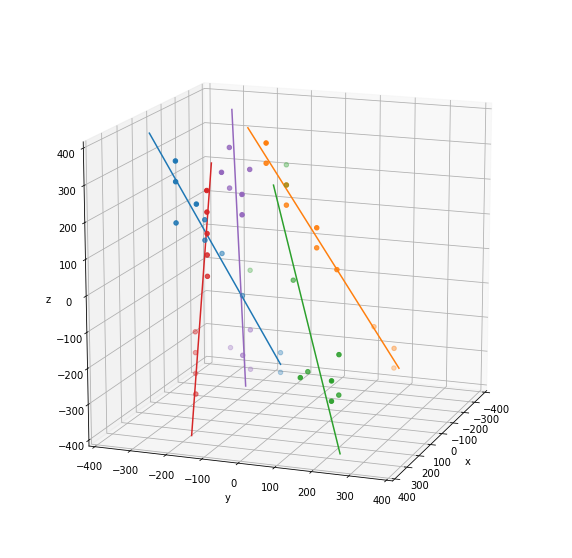

In [376]:
# AGAIN NOT MY CODE

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(0,5):
    ax.scatter3D(*listofcoords[i])
    ax.plot3D(*lines[i].T)

plt.xlim([-400,400])
plt.ylim([-400,400])
ax.set_zlim([-400,400])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(15, 20)

IndexError: list index out of range

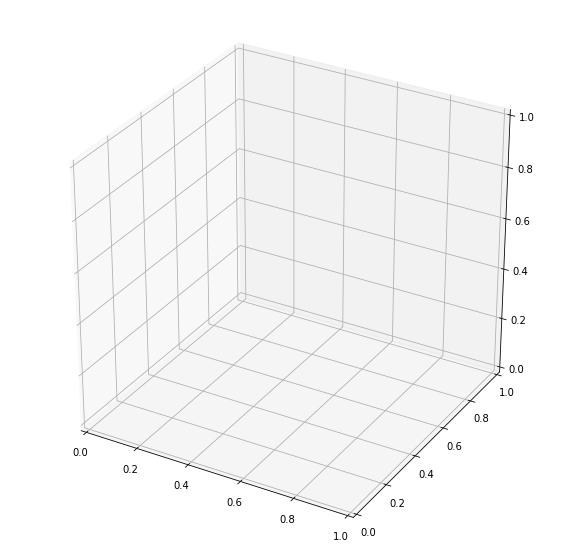

In [383]:
import time

for i in range(23,24):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(*listofcoords[i])
    ax.plot3D(*lines[i].T)


    plt.xlim([-400,400])
    plt.ylim([-400,400])
    ax.set_zlim([-400,400])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.view_init(15, 69)
    
    plt.show()

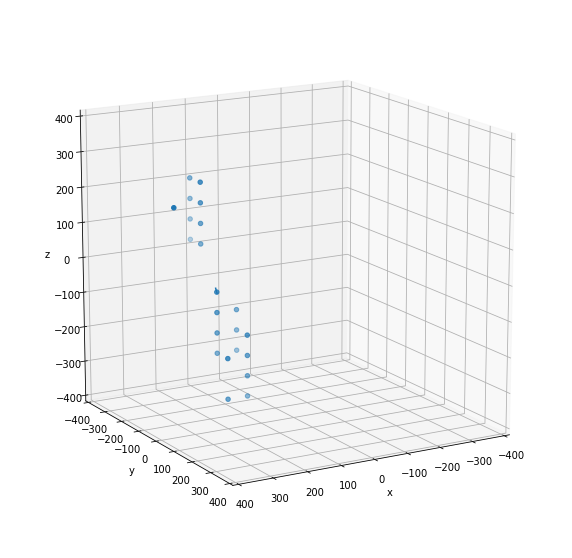

In [104]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(original_coords[0], original_coords[1], original_coords[2])
#ax.plot([0,200], [0,200], [-483.2,200*.8679 - 200*2.1022], c='r')
#plt.scatter(0,0,0, marker='.')
ax.plot3D(*linepts.T)

plt.xlim([-400,400])
plt.ylim([-400,400])
ax.set_zlim([-400,400])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(15, 60)

In [29]:
# VARIABLE PARAMETERS
time_thresholds = [.1, .5, 1]

var_timedata = [get_channelspercluster(get_clusterdata(louddata, 5, t)) for t in time_thresholds]

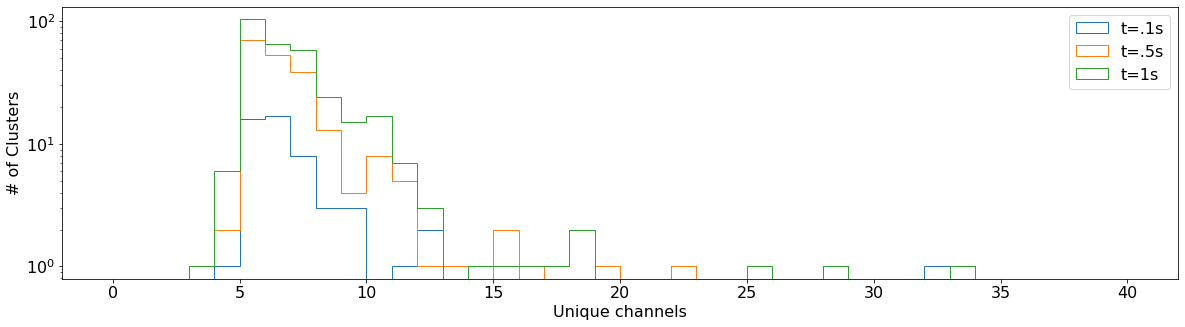

In [201]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('# of Clusters',fontsize=16)
plt.xlabel('Unique channels',fontsize=16)

#array=plt.hist(get_channelspercluster(timeclusterdata), np.linspace(0,40,41), histtype='step')

array=plt.hist(var_timedata[0], np.linspace(0,40,41), histtype='step', label='t=.1s')
array=plt.hist(var_timedata[1], np.linspace(0,40,41), histtype='step', label='t=.5s')
array=plt.hist(var_timedata[2], np.linspace(0,40,41), histtype='step', label='t=1s')
plt.legend(fontsize=16)
plt.gca().set_yscale("log")

NameError: name 'listof_numofevents' is not defined

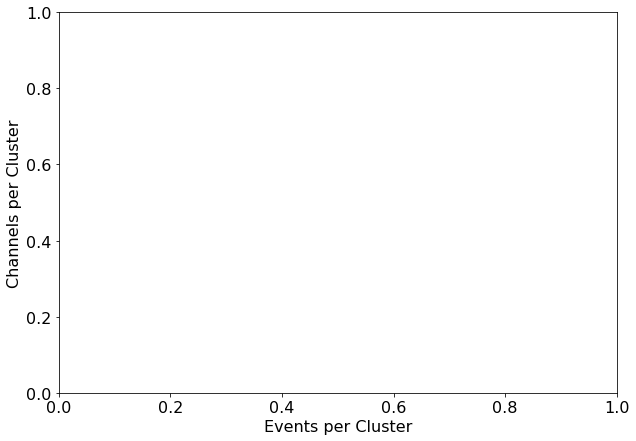

In [31]:
#Scatter plot:
plt.figure(figsize=(10,7)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
#plt.title('First 3 Towers of ds3564',fontsize=16)
plt.xlabel('Events per Cluster',fontsize=16)
plt.ylabel('Channels per Cluster',fontsize=16)

plt.scatter(listof_numofevents,listof_uniquechannels, marker='.',s=100)
#plt.gca().set_yscale("log") #set y-scale to be logarithmic (x-scale works the same way)
plt.ylim([0,30])
plt.xlim([0,30])

In [ ]:
timeclusterdata['Channel']
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('Cluster #',fontsize=16)
array=plt.hist(timeclusterdata['Cluster'], np.linspace(0,40,41), histtype='step')
#plt.gca().set_yscale("log")

In [ ]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('MaxToBaseline+Baseline',fontsize=16)
array=plt.hist(not_noisydata['MaxToBaseline'].values+not_noisydata['Baseline'].values, np.linspace(9000,9800,1001), histtype='step')
plt.gca().set_yscale("log")

In [ ]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Number of Events',fontsize=16)
plt.xlabel('MaxToBaseline+Baseline',fontsize=16)
array=plt.hist(louddata['MaxToBaseline'].values+louddata['Baseline'].values, np.linspace(0,9800,9801), histtype='step')
plt.gca().set_yscale("log")

In [ ]:
plt.figure(figsize=(20,5)) # lets you make a custom size for your plot
plt.tick_params(labelsize=16) #adjust fontsize of axis ticks
plt.ylabel('Events',fontsize=16)
plt.xlabel('Time',fontsize=16)
array=plt.hist(timeclusterdata['Time'].values, np.linspace(0,84500,84501), histtype='step')
#plt.gca().set_yscale("log")